In [8]:
import gzip
import pickle
import numpy as np
from pathlib import Path
import torch
from  acr_bb import Observation, ACRBBenv, DefaultBranchingPolicy, RandomPolicy, LinearObservation
from fcn_policy import FCNDataset, FCNBranchingPolicy, FCNNodeSelectionPolicy 

MAX_SAMPLES = 100000

N = 8 # antennas
M = 4 # users
expert_prob = 0.5

def instance_generator(M, N):
    while 1:
        yield np.random.randn(2,N,M)

# instances = np.random.randn(MAX_SAMPLES, 2, N, M)
instances = instance_generator(M,N)

env = ACRBBenv()

expert_policy = DefaultBranchingPolicy()
random_policy = RandomPolicy()

In [9]:
episode_counter, sample_counter = 0, 10000
Path('positive_node_samples/').mkdir(exist_ok=True)
Path('negative_node_samples/').mkdir(exist_ok=True)

# We will solve problems (run episodes) until we have saved enough samples
max_samples_reached = False

while not max_samples_reached:
    episode_counter += 1
    
    observation_list = []
    node_indices = []
    observation, action_set, reward, done, _ = env.reset(next(instances))
    node_indices.append(env.active_node.node_index)
    observation_list.append(observation)
    while not done and reward > -5:
        if np.random.rand(1) > expert_prob:
            action_id = expert_policy.select_variable(observation, action_set)
        else:
            action_id = random_policy.select_variable(observation, action_set)

        observation, action_set, reward, done, _ = env.step(action_id)
    
    for node in env.all_nodes:
        if node.optimal:
            for i in range(len(node_indices)):
                if node_indices[i] == node.node_index:
                    data = [observation_list[i], True]
                    break
        else:
            for i in range(len(node_indices)):
                if node_indices[i] == node.node_index:
                    data = [observation_list[i], False]
                    break
            
        if not max_samples_reached:
            sample_counter += 1
            
            if node.optimal:
                filename = f'positive_node_samples/sample_{sample_counter}.pkl'
            else:
                filename = f'negative_node_samples/sample_{sample_counter}.pkl'
                
            with gzip.open(filename, 'wb') as f:
                pickle.dump(data, f)
            # If we collected enough samples, we finish the current episode but stop saving samples
            if sample_counter >= MAX_SAMPLES:
                max_samples_reached = True
                break;
    print(f"Episode {episode_counter}, {sample_counter} samples collected so far")


Episode 1, 571 samples collected so far
Episode 2, 1210 samples collected so far
Episode 3, 1463 samples collected so far
Episode 4, 2024 samples collected so far
Episode 5, 2385 samples collected so far
Episode 6, 2938 samples collected so far
Episode 7, 3861 samples collected so far
Episode 8, 5330 samples collected so far
Episode 9, 6307 samples collected so far
Episode 10, 7234 samples collected so far
Episode 11, 8493 samples collected so far
Episode 12, 11502 samples collected so far
Episode 13, 13549 samples collected so far
Episode 14, 14962 samples collected so far
Episode 15, 16523 samples collected so far
Episode 16, 17244 samples collected so far
Episode 17, 18419 samples collected so far
Episode 18, 18930 samples collected so far
Episode 19, 22365 samples collected so far
Episode 20, 23004 samples collected so far
Episode 21, 23929 samples collected so far
Episode 22, 24652 samples collected so far
Episode 23, 25699 samples collected so far
Episode 24, 27212 samples collec

In [1]:
import torch
import torch.nn.functional as F
import torch_geometric
from gnn_dataset import BipartiteNodeData, GraphNodeDataset
from gnn_policy import GNNPolicy, BipartiteGraphConvolution
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import matplotlib.pyplot as plt


LEARNING_RATE = 0.001
NB_EPOCHS = 50
PATIENCE = 10
EARLY_STOPPING = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sig = nn.Sigmoid()

def process(policy, data_loader, optimizer=None):
    """
    This function will process a whole epoch of training or validation, depending on whether an optimizer is provided.
    """
    mean_loss = 0
    mean_acc = 0

    n_samples_processed = 0
    targets_list = torch.Tensor([]).to(DEVICE)
    preds_list = torch.Tensor([]).to(DEVICE)
    with torch.set_grad_enabled(optimizer is not None):
        for batch_data in tqdm(data_loader):
            batch, target = batch_data
            batch = batch.to(DEVICE)
            target = target.to(DEVICE)*1
#             print(target)
            logits = policy(batch.antenna_features, batch.edge_index, batch.edge_attr, batch.variable_features)            
            logits = logits.reshape([batch.num_graphs, -1]).sum(dim=1)
            wts = target*29
            wts = wts+1
            bce = nn.BCEWithLogitsLoss(weight=wts)
            
            loss = bce(logits, target.to(torch.float))
            
            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
#             print('target and wts', target, wts)
            predicted_bestindex = (sig(logits)>0.5)*1
#             print('prediction', predicted_bestindex)
            accuracy = sum(predicted_bestindex.reshape(-1) == target)
            
            targets_list = torch.cat((targets_list, target))
            preds_list = torch.cat((preds_list, predicted_bestindex))
#             accuracy = (true_scores.gather(-1, predicted_bestindex) == true_bestscore).float().mean().item()

            mean_loss += loss.item() * batch.num_graphs
            mean_acc += float(accuracy)
            n_samples_processed += batch.num_graphs
#             if n_samples_processed > 500:
#                 break
    stacked = torch.stack((targets_list, preds_list), dim=1).to(torch.int)
    cmt = torch.zeros(2,2,dtype=torch.int64)
    for p in stacked:
        tl, pl = p.tolist()
        cmt[tl, pl] = cmt[tl, pl] + 1
    print(cmt)
    mean_loss /= n_samples_processed
    mean_acc /= n_samples_processed
    return mean_loss, mean_acc


def pad_tensor(input_, pad_sizes, pad_value=-1e8):
    """
    This utility function splits a tensor and pads each split to make them all the same size, then stacks them.
    """
    max_pad_size = pad_sizes.max()
    output = input_.split(pad_sizes.cpu().numpy().tolist())
    output = torch.stack([F.pad(slice_, (0, max_pad_size-slice_.size(0)), 'constant', pad_value)
                          for slice_ in output], dim=0)
    return output


sample_files = [str(path) for path in Path('node_samples/').glob('sample_*.pkl')]
train_files = sample_files[:int(0.8*len(sample_files))]
valid_files = sample_files[int(0.8*len(sample_files)):]

train_data = GraphNodeDataset(train_files)
train_loader = torch_geometric.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_data = GraphNodeDataset(valid_files)
valid_loader = torch_geometric.data.DataLoader(valid_data, batch_size=64, shuffle=False)

policy = GNNPolicy().to(DEVICE)
optimizer = torch.optim.Adam(policy.parameters(), lr=LEARNING_RATE)

valids = []
for epoch in range(NB_EPOCHS):
    print(f"Epoch {epoch+1}")
    
    train_loss, train_acc = process(policy, train_loader, optimizer)
    print(f"Train loss: {train_loss:0.3f}, accuracy {train_acc:0.3f}" )

    valid_loss, valid_acc = process(policy, valid_loader, None)
    print(f"Valid loss: {valid_loss:0.3f}, accuracy {valid_acc:0.3f}" )
    valids.append(valid_acc)

torch.save(policy.state_dict(), 'trained_params.pkl')

/scratch/sagar/Projects/combopt/venv/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1


  6%|▌         | 74/1250 [00:02<00:36, 32.00it/s]


KeyboardInterrupt: 

# Random Over-Sampling

In [ ]:
import torch
import torch.nn.functional as F
import torch_geometric
from gnn_dataset import BipartiteNodeData, GraphNodeDataset
from gnn_policy import GNNPolicy, BipartiteGraphConvolution
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import math 

LEARNING_RATE = 0.001
NB_EPOCHS = 150
PATIENCE = 10
EARLY_STOPPING = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sig = nn.Sigmoid()

def process(policy, data_loader, optimizer=None):
    """
    This function will process a whole epoch of training or validation, depending on whether an optimizer is provided.
    """
    mean_loss = 0
    mean_acc = 0

    n_samples_processed = 0
    targets_list = torch.Tensor([]).to(DEVICE)
    preds_list = torch.Tensor([]).to(DEVICE)
    with torch.set_grad_enabled(optimizer is not None):
        for batch_data in tqdm(data_loader):
            batch, target = batch_data
            batch = batch.to(DEVICE)
            target = target.to(DEVICE)*1

            logits = policy(batch.antenna_features, batch.edge_index, batch.edge_attr, batch.variable_features)            
            logits = logits.reshape([batch.num_graphs, -1]).sum(dim=1)
#             wts = target*29
#             wts = wts+1
#             bce = nn.BCEWithLogitsLoss(weight=wts)
            bce = nn.BCEWithLogitsLoss()

            
            loss = bce(logits, target.to(torch.float))
            
            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            predicted_bestindex = (sig(logits)>0.5)*1
            accuracy = sum(predicted_bestindex.reshape(-1) == target)
            
            targets_list = torch.cat((targets_list, target))
            preds_list = torch.cat((preds_list, predicted_bestindex))

            mean_loss += loss.item() * batch.num_graphs
            mean_acc += float(accuracy)
            n_samples_processed += batch.num_graphs

    stacked = torch.stack((targets_list, preds_list), dim=1).to(torch.int)
    cmt = torch.zeros(2,2,dtype=torch.int64)
    for p in stacked:
        tl, pl = p.tolist()
        cmt[tl, pl] = cmt[tl, pl] + 1
    print(cmt)
    precision = cmt[1,1]/(cmt[0,1]+cmt[1,1])
    recall = cmt[1,1]/(cmt[1,0]+cmt[1,1])
    mean_acc = 2* (precision*recall)/(precision+recall)
    mean_loss /= n_samples_processed
#     mean_acc /= n_samples_processed
    return mean_loss, mean_acc


def pad_tensor(input_, pad_sizes, pad_value=-1e8):
    """
    This utility function splits a tensor and pads each split to make them all the same size, then stacks them.
    """
    max_pad_size = pad_sizes.max()
    output = input_.split(pad_sizes.cpu().numpy().tolist())
    output = torch.stack([F.pad(slice_, (0, max_pad_size-slice_.size(0)), 'constant', pad_value)
                          for slice_ in output], dim=0)
    return output



# positive_sample_files1 = [str(path) for path in Path('positive_node_samples2/').glob('sample_*.pkl')]
positive_sample_files2 = [str(path) for path in Path('positive_node_samples3/').glob('sample_*.pkl')]
positive_sample_files1 = []
positive_sample_files = positive_sample_files1 + positive_sample_files2

negative_sample_files = [str(path) for path in Path('negative_node_samples3/').glob('sample_*.pkl')]
random.shuffle(negative_sample_files)
negative_sample_files = negative_sample_files[:100000]
imbalance_ratio = len(negative_sample_files)/len(positive_sample_files)


positive_sample_files = positive_sample_files*math.ceil(imbalance_ratio)
print(len(positive_sample_files), len(negative_sample_files))
sample_files = positive_sample_files + negative_sample_files
random.shuffle(sample_files)

valid_sample_files = [str(path) for path in Path('node_samples/').glob('sample_*.pkl')]
random.shuffle(valid_sample_files)
valid_sample_files = valid_sample_files[:2000]

train_files = sample_files[:int(0.8*len(sample_files))]
valid_files = sample_files[int(0.8*len(sample_files)):]
train_data = GraphNodeDataset(train_files)
train_loader = torch_geometric.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_data = GraphNodeDataset(valid_files)
valid_loader = torch_geometric.data.DataLoader(valid_data, batch_size=64, shuffle=False)

policy = GNNPolicy().to(DEVICE)
optimizer = torch.optim.Adam(policy.parameters(), lr=LEARNING_RATE)

valids = []
for epoch in range(NB_EPOCHS):
    print(f"Epoch {epoch+1}")
    
    train_loss, train_acc = process(policy, train_loader, optimizer)
    print(f"Train loss: {train_loss:0.3f}, accuracy {train_acc:0.3f}" )

    valid_loss, valid_acc = process(policy, valid_loader, None)
    print(f"Valid loss: {valid_loss:0.3f}, accuracy {valid_acc:0.3f}" )
    valids.append(valid_acc)

torch.save(policy.state_dict(), 'trained_params_ros.pkl')

100000 100000
Epoch 1


100%|██████████| 2500/2500 [01:04<00:00, 38.83it/s]


tensor([[52121, 27731],
        [45263, 34885]])
Train loss: 0.687, accuracy 0.489


100%|██████████| 625/625 [00:12<00:00, 49.33it/s]


tensor([[12466,  7682],
        [10498,  9354]])
Valid loss: 0.684, accuracy 0.507
Epoch 2


100%|██████████| 2500/2500 [01:03<00:00, 39.33it/s]


tensor([[52712, 27140],
        [44051, 36097]])
Train loss: 0.683, accuracy 0.503


100%|██████████| 625/625 [00:12<00:00, 49.69it/s]


tensor([[10226,  9922],
        [ 7430, 12422]])
Valid loss: 0.683, accuracy 0.589
Epoch 3


100%|██████████| 2500/2500 [01:05<00:00, 38.26it/s]


tensor([[51998, 27854],
        [40985, 39163]])
Train loss: 0.681, accuracy 0.532


100%|██████████| 625/625 [00:12<00:00, 49.10it/s]


tensor([[10218,  9930],
        [ 7233, 12619]])
Valid loss: 0.681, accuracy 0.595
Epoch 4


100%|██████████| 2500/2500 [01:08<00:00, 36.32it/s]


tensor([[50849, 29003],
        [39594, 40554]])
Train loss: 0.679, accuracy 0.542


100%|██████████| 625/625 [00:13<00:00, 44.85it/s]


tensor([[15551,  4597],
        [12614,  7238]])
Valid loss: 0.680, accuracy 0.457
Epoch 5


100%|██████████| 2500/2500 [01:08<00:00, 36.49it/s]


tensor([[50014, 29838],
        [38517, 41631]])
Train loss: 0.678, accuracy 0.549


100%|██████████| 625/625 [00:12<00:00, 48.28it/s]


tensor([[12247,  7901],
        [ 8982, 10870]])
Valid loss: 0.676, accuracy 0.563
Epoch 6


100%|██████████| 2500/2500 [01:04<00:00, 38.97it/s]


tensor([[49524, 30328],
        [37789, 42359]])
Train loss: 0.676, accuracy 0.554


100%|██████████| 625/625 [00:14<00:00, 43.00it/s]


tensor([[15080,  5068],
        [12076,  7776]])
Valid loss: 0.677, accuracy 0.476
Epoch 7


100%|██████████| 2500/2500 [01:16<00:00, 32.71it/s]


tensor([[49893, 29959],
        [37633, 42515]])
Train loss: 0.675, accuracy 0.557


100%|██████████| 625/625 [00:14<00:00, 42.49it/s]


tensor([[ 7820, 12328],
        [ 5217, 14635]])
Valid loss: 0.681, accuracy 0.625
Epoch 8


100%|██████████| 2500/2500 [01:08<00:00, 36.41it/s]


tensor([[49774, 30078],
        [37421, 42727]])
Train loss: 0.673, accuracy 0.559


100%|██████████| 625/625 [00:12<00:00, 49.46it/s]


tensor([[11068,  9080],
        [ 7762, 12090]])
Valid loss: 0.673, accuracy 0.589
Epoch 9


100%|██████████| 2500/2500 [01:04<00:00, 38.89it/s]


tensor([[49987, 29865],
        [37266, 42882]])
Train loss: 0.672, accuracy 0.561


100%|██████████| 625/625 [00:12<00:00, 49.80it/s]


tensor([[10597,  9551],
        [ 7219, 12633]])
Valid loss: 0.672, accuracy 0.601
Epoch 10


100%|██████████| 2500/2500 [01:04<00:00, 38.97it/s]


tensor([[50361, 29491],
        [37168, 42980]])
Train loss: 0.670, accuracy 0.563


100%|██████████| 625/625 [00:12<00:00, 49.04it/s]


tensor([[12611,  7537],
        [ 9191, 10661]])
Valid loss: 0.672, accuracy 0.560
Epoch 11


100%|██████████| 2500/2500 [01:04<00:00, 38.81it/s]


tensor([[50375, 29477],
        [36492, 43656]])
Train loss: 0.669, accuracy 0.570


100%|██████████| 625/625 [00:12<00:00, 49.12it/s]


tensor([[13986,  6162],
        [10110,  9742]])
Valid loss: 0.666, accuracy 0.545
Epoch 12


100%|██████████| 2500/2500 [01:04<00:00, 38.60it/s]


tensor([[49845, 30007],
        [35509, 44639]])
Train loss: 0.667, accuracy 0.577


100%|██████████| 625/625 [00:12<00:00, 49.77it/s]


tensor([[10928,  9220],
        [ 7123, 12729]])
Valid loss: 0.666, accuracy 0.609
Epoch 13


100%|██████████| 2500/2500 [01:03<00:00, 39.68it/s]


tensor([[49233, 30619],
        [34453, 45695]])
Train loss: 0.666, accuracy 0.584


100%|██████████| 625/625 [00:12<00:00, 49.15it/s]


tensor([[12273,  7875],
        [ 8159, 11693]])
Valid loss: 0.665, accuracy 0.593
Epoch 14


100%|██████████| 2500/2500 [01:04<00:00, 38.89it/s]


tensor([[49433, 30419],
        [33991, 46157]])
Train loss: 0.663, accuracy 0.589


100%|██████████| 625/625 [00:12<00:00, 49.25it/s]


tensor([[12568,  7580],
        [ 9053, 10799]])
Valid loss: 0.668, accuracy 0.565
Epoch 15


100%|██████████| 2500/2500 [01:04<00:00, 38.63it/s]


tensor([[49119, 30733],
        [34018, 46130]])
Train loss: 0.664, accuracy 0.588


100%|██████████| 625/625 [00:12<00:00, 49.08it/s]


tensor([[13140,  7008],
        [ 9975,  9877]])
Valid loss: 0.677, accuracy 0.538
Epoch 16


100%|██████████| 2500/2500 [01:04<00:00, 38.52it/s]


tensor([[49553, 30299],
        [34447, 45701]])
Train loss: 0.664, accuracy 0.585


100%|██████████| 625/625 [00:12<00:00, 49.10it/s]


tensor([[12050,  8098],
        [ 7746, 12106]])
Valid loss: 0.661, accuracy 0.604
Epoch 17


100%|██████████| 2500/2500 [01:03<00:00, 39.25it/s]


tensor([[49166, 30686],
        [33105, 47043]])
Train loss: 0.660, accuracy 0.596


100%|██████████| 625/625 [00:12<00:00, 48.45it/s]


tensor([[13088,  7060],
        [ 8930, 10922]])
Valid loss: 0.660, accuracy 0.577
Epoch 18


100%|██████████| 2500/2500 [01:05<00:00, 38.35it/s]


tensor([[49476, 30376],
        [33335, 46813]])
Train loss: 0.660, accuracy 0.595


100%|██████████| 625/625 [00:12<00:00, 48.31it/s]


tensor([[11155,  8993],
        [ 6912, 12940]])
Valid loss: 0.659, accuracy 0.619
Epoch 19


100%|██████████| 2500/2500 [01:05<00:00, 38.26it/s]


tensor([[48920, 30932],
        [32335, 47813]])
Train loss: 0.659, accuracy 0.602


100%|██████████| 625/625 [00:12<00:00, 48.67it/s]


tensor([[14608,  5540],
        [10622,  9230]])
Valid loss: 0.664, accuracy 0.533
Epoch 20


100%|██████████| 2500/2500 [01:06<00:00, 37.59it/s]


tensor([[48528, 31324],
        [31838, 48310]])
Train loss: 0.658, accuracy 0.605


100%|██████████| 625/625 [00:12<00:00, 49.00it/s]


tensor([[14003,  6145],
        [10185,  9667]])
Valid loss: 0.669, accuracy 0.542
Epoch 21


100%|██████████| 2500/2500 [01:06<00:00, 37.48it/s]


tensor([[48672, 31180],
        [31728, 48420]])
Train loss: 0.657, accuracy 0.606


100%|██████████| 625/625 [00:12<00:00, 48.72it/s]


tensor([[12572,  7576],
        [ 8202, 11650]])
Valid loss: 0.657, accuracy 0.596
Epoch 22


100%|██████████| 2500/2500 [01:05<00:00, 38.18it/s]


tensor([[48480, 31372],
        [31541, 48607]])
Train loss: 0.656, accuracy 0.607


100%|██████████| 625/625 [00:12<00:00, 49.36it/s]


tensor([[10189,  9959],
        [ 5979, 13873]])
Valid loss: 0.662, accuracy 0.635
Epoch 23


100%|██████████| 2500/2500 [01:06<00:00, 37.67it/s]


tensor([[48558, 31294],
        [31277, 48871]])
Train loss: 0.655, accuracy 0.610


100%|██████████| 625/625 [00:13<00:00, 46.88it/s]


tensor([[13063,  7085],
        [ 8679, 11173]])
Valid loss: 0.657, accuracy 0.586
Epoch 24


100%|██████████| 2500/2500 [01:05<00:00, 38.42it/s]


tensor([[48607, 31245],
        [31180, 48968]])
Train loss: 0.655, accuracy 0.611


100%|██████████| 625/625 [00:12<00:00, 48.69it/s]


tensor([[11498,  8650],
        [ 6988, 12864]])
Valid loss: 0.657, accuracy 0.622
Epoch 25


100%|██████████| 2500/2500 [01:10<00:00, 35.22it/s]


tensor([[48589, 31263],
        [30841, 49307]])
Train loss: 0.654, accuracy 0.614


100%|██████████| 625/625 [00:12<00:00, 50.44it/s]


tensor([[13510,  6638],
        [ 9315, 10537]])
Valid loss: 0.657, accuracy 0.569
Epoch 26


100%|██████████| 2500/2500 [01:06<00:00, 37.44it/s]


tensor([[48756, 31096],
        [31070, 49078]])
Train loss: 0.654, accuracy 0.612


100%|██████████| 625/625 [00:13<00:00, 47.89it/s]


tensor([[12480,  7668],
        [ 8035, 11817]])
Valid loss: 0.657, accuracy 0.601
Epoch 27


100%|██████████| 2500/2500 [01:05<00:00, 38.39it/s]


tensor([[48667, 31185],
        [30802, 49346]])
Train loss: 0.654, accuracy 0.614


100%|██████████| 625/625 [00:12<00:00, 48.50it/s]


tensor([[13092,  7056],
        [ 8472, 11380]])
Valid loss: 0.653, accuracy 0.594
Epoch 28


100%|██████████| 2500/2500 [01:05<00:00, 38.04it/s]


tensor([[48555, 31297],
        [30594, 49554]])
Train loss: 0.653, accuracy 0.616


100%|██████████| 625/625 [00:12<00:00, 48.81it/s]


tensor([[12490,  7658],
        [ 7871, 11981]])
Valid loss: 0.654, accuracy 0.607
Epoch 29


100%|██████████| 2500/2500 [01:09<00:00, 36.03it/s]


tensor([[48474, 31378],
        [30567, 49581]])
Train loss: 0.653, accuracy 0.616


100%|██████████| 625/625 [00:12<00:00, 49.14it/s]


tensor([[11796,  8352],
        [ 7127, 12725]])
Valid loss: 0.654, accuracy 0.622
Epoch 30


100%|██████████| 2500/2500 [01:05<00:00, 38.40it/s]


tensor([[48590, 31262],
        [30547, 49601]])
Train loss: 0.653, accuracy 0.616


100%|██████████| 625/625 [00:12<00:00, 48.39it/s]


tensor([[11072,  9076],
        [ 6566, 13286]])
Valid loss: 0.656, accuracy 0.629
Epoch 31


100%|██████████| 2500/2500 [01:05<00:00, 38.32it/s]


tensor([[48829, 31023],
        [30672, 49476]])
Train loss: 0.652, accuracy 0.616


100%|██████████| 625/625 [00:12<00:00, 49.30it/s]


tensor([[10993,  9155],
        [ 6365, 13487]])
Valid loss: 0.654, accuracy 0.635
Epoch 32


100%|██████████| 2500/2500 [01:05<00:00, 38.07it/s]


tensor([[48728, 31124],
        [30527, 49621]])
Train loss: 0.652, accuracy 0.617


100%|██████████| 625/625 [00:12<00:00, 48.87it/s]


tensor([[11416,  8732],
        [ 7041, 12811]])
Valid loss: 0.655, accuracy 0.619
Epoch 33


100%|██████████| 2500/2500 [01:06<00:00, 37.41it/s]


tensor([[48788, 31064],
        [30594, 49554]])
Train loss: 0.652, accuracy 0.616


100%|██████████| 625/625 [00:12<00:00, 49.02it/s]


tensor([[13446,  6702],
        [ 8972, 10880]])
Valid loss: 0.654, accuracy 0.581
Epoch 34


100%|██████████| 2500/2500 [01:04<00:00, 38.78it/s]


tensor([[48567, 31285],
        [30418, 49730]])
Train loss: 0.652, accuracy 0.617


100%|██████████| 625/625 [00:12<00:00, 49.63it/s]


tensor([[11921,  8227],
        [ 7401, 12451]])
Valid loss: 0.653, accuracy 0.614
Epoch 35


100%|██████████| 2500/2500 [01:04<00:00, 38.84it/s]


tensor([[48569, 31283],
        [30406, 49742]])
Train loss: 0.652, accuracy 0.617


100%|██████████| 625/625 [00:12<00:00, 50.58it/s]


tensor([[10711,  9437],
        [ 6142, 13710]])
Valid loss: 0.656, accuracy 0.638
Epoch 36


100%|██████████| 2500/2500 [01:06<00:00, 37.49it/s]


tensor([[48723, 31129],
        [30304, 49844]])
Train loss: 0.652, accuracy 0.619


100%|██████████| 625/625 [00:12<00:00, 48.84it/s]


tensor([[12274,  7874],
        [ 7506, 12346]])
Valid loss: 0.652, accuracy 0.616
Epoch 37


100%|██████████| 2500/2500 [01:05<00:00, 38.25it/s]


tensor([[48658, 31194],
        [30398, 49750]])
Train loss: 0.652, accuracy 0.618


100%|██████████| 625/625 [00:12<00:00, 49.02it/s]


tensor([[12952,  7196],
        [ 8207, 11645]])
Valid loss: 0.654, accuracy 0.602
Epoch 38


100%|██████████| 2500/2500 [01:04<00:00, 38.51it/s]


tensor([[48847, 31005],
        [30566, 49582]])
Train loss: 0.652, accuracy 0.617


100%|██████████| 625/625 [00:12<00:00, 48.76it/s]


tensor([[11329,  8819],
        [ 6571, 13281]])
Valid loss: 0.654, accuracy 0.633
Epoch 39


100%|██████████| 2500/2500 [01:05<00:00, 38.15it/s]


tensor([[48877, 30975],
        [30349, 49799]])
Train loss: 0.651, accuracy 0.619


100%|██████████| 625/625 [00:12<00:00, 48.41it/s]


tensor([[12548,  7600],
        [ 7847, 12005]])
Valid loss: 0.652, accuracy 0.609
Epoch 40


100%|██████████| 2500/2500 [01:13<00:00, 34.19it/s]


tensor([[48815, 31037],
        [30301, 49847]])
Train loss: 0.651, accuracy 0.619


100%|██████████| 625/625 [00:13<00:00, 47.82it/s]


tensor([[13259,  6889],
        [ 8575, 11277]])
Valid loss: 0.652, accuracy 0.593
Epoch 41


100%|██████████| 2500/2500 [01:04<00:00, 38.93it/s]


tensor([[48587, 31265],
        [30083, 50065]])
Train loss: 0.651, accuracy 0.620


100%|██████████| 625/625 [00:12<00:00, 48.78it/s]


tensor([[12103,  8045],
        [ 7320, 12532]])
Valid loss: 0.652, accuracy 0.620
Epoch 42


100%|██████████| 2500/2500 [01:04<00:00, 38.53it/s]


tensor([[48718, 31134],
        [30127, 50021]])
Train loss: 0.651, accuracy 0.620


100%|██████████| 625/625 [00:12<00:00, 48.64it/s]


tensor([[12084,  8064],
        [ 7295, 12557]])
Valid loss: 0.651, accuracy 0.621
Epoch 43


100%|██████████| 2500/2500 [01:04<00:00, 38.74it/s]


tensor([[48611, 31241],
        [30266, 49882]])
Train loss: 0.651, accuracy 0.619


100%|██████████| 625/625 [00:12<00:00, 48.56it/s]


tensor([[12256,  7892],
        [ 7649, 12203]])
Valid loss: 0.652, accuracy 0.611
Epoch 44


100%|██████████| 2500/2500 [01:05<00:00, 38.15it/s]


tensor([[48883, 30969],
        [30390, 49758]])
Train loss: 0.651, accuracy 0.619


100%|██████████| 625/625 [00:12<00:00, 48.91it/s]


tensor([[12463,  7685],
        [ 7817, 12035]])
Valid loss: 0.653, accuracy 0.608
Epoch 45


100%|██████████| 2500/2500 [01:04<00:00, 38.93it/s]


tensor([[48764, 31088],
        [30239, 49909]])
Train loss: 0.651, accuracy 0.619


100%|██████████| 625/625 [00:12<00:00, 48.68it/s]


tensor([[12688,  7460],
        [ 7975, 11877]])
Valid loss: 0.652, accuracy 0.606
Epoch 46


100%|██████████| 2500/2500 [01:05<00:00, 38.40it/s]


tensor([[48834, 31018],
        [30213, 49935]])
Train loss: 0.650, accuracy 0.620


100%|██████████| 625/625 [00:12<00:00, 49.05it/s]


tensor([[13626,  6522],
        [ 9066, 10786]])
Valid loss: 0.655, accuracy 0.581
Epoch 47


100%|██████████| 2500/2500 [01:06<00:00, 37.32it/s]


tensor([[48712, 31140],
        [29999, 50149]])
Train loss: 0.650, accuracy 0.621


100%|██████████| 625/625 [00:12<00:00, 48.11it/s]


tensor([[12403,  7745],
        [ 7601, 12251]])
Valid loss: 0.651, accuracy 0.615
Epoch 48


100%|██████████| 2500/2500 [01:10<00:00, 35.37it/s]


tensor([[48828, 31024],
        [30325, 49823]])
Train loss: 0.650, accuracy 0.619


100%|██████████| 625/625 [00:12<00:00, 48.90it/s]


tensor([[11599,  8549],
        [ 6926, 12926]])
Valid loss: 0.652, accuracy 0.626
Epoch 49


100%|██████████| 2500/2500 [01:04<00:00, 38.71it/s]


tensor([[48728, 31124],
        [30179, 49969]])
Train loss: 0.650, accuracy 0.620


100%|██████████| 625/625 [00:12<00:00, 48.30it/s]


tensor([[12801,  7347],
        [ 8192, 11660]])
Valid loss: 0.652, accuracy 0.600
Epoch 50


100%|██████████| 2500/2500 [01:05<00:00, 37.95it/s]


tensor([[49025, 30827],
        [30245, 49903]])
Train loss: 0.650, accuracy 0.620


100%|██████████| 625/625 [00:12<00:00, 49.05it/s]


tensor([[11574,  8574],
        [ 6844, 13008]])
Valid loss: 0.651, accuracy 0.628
Epoch 51


100%|██████████| 2500/2500 [01:05<00:00, 38.14it/s]


tensor([[48520, 31332],
        [29816, 50332]])
Train loss: 0.650, accuracy 0.622


100%|██████████| 625/625 [00:12<00:00, 48.45it/s]


tensor([[12658,  7490],
        [ 7918, 11934]])
Valid loss: 0.650, accuracy 0.608
Epoch 52


100%|██████████| 2500/2500 [01:05<00:00, 37.94it/s]


tensor([[49101, 30751],
        [30393, 49755]])
Train loss: 0.650, accuracy 0.619


100%|██████████| 625/625 [00:12<00:00, 49.51it/s]


tensor([[12592,  7556],
        [ 7790, 12062]])
Valid loss: 0.651, accuracy 0.611
Epoch 53


100%|██████████| 2500/2500 [01:04<00:00, 38.52it/s]


tensor([[48888, 30964],
        [30314, 49834]])
Train loss: 0.650, accuracy 0.619


100%|██████████| 625/625 [00:12<00:00, 48.21it/s]


tensor([[13576,  6572],
        [ 8819, 11033]])
Valid loss: 0.651, accuracy 0.589
Epoch 54


100%|██████████| 2500/2500 [01:07<00:00, 37.03it/s]


tensor([[48722, 31130],
        [30092, 50056]])
Train loss: 0.650, accuracy 0.621


100%|██████████| 625/625 [00:13<00:00, 46.95it/s]


tensor([[12068,  8080],
        [ 7294, 12558]])
Valid loss: 0.651, accuracy 0.620
Epoch 55


100%|██████████| 2500/2500 [01:04<00:00, 38.68it/s]


tensor([[48677, 31175],
        [29863, 50285]])
Train loss: 0.650, accuracy 0.622


100%|██████████| 625/625 [00:12<00:00, 49.26it/s]


tensor([[13792,  6356],
        [ 9199, 10653]])
Valid loss: 0.653, accuracy 0.578
Epoch 56


100%|██████████| 2500/2500 [01:09<00:00, 36.04it/s]


tensor([[48964, 30888],
        [30081, 50067]])
Train loss: 0.650, accuracy 0.622


100%|██████████| 625/625 [00:14<00:00, 44.13it/s]


tensor([[12730,  7418],
        [ 7974, 11878]])
Valid loss: 0.651, accuracy 0.607
Epoch 57


100%|██████████| 2500/2500 [01:05<00:00, 38.44it/s]


tensor([[49058, 30794],
        [30313, 49835]])
Train loss: 0.650, accuracy 0.620


100%|██████████| 625/625 [00:12<00:00, 48.72it/s]


tensor([[13223,  6925],
        [ 8476, 11376]])
Valid loss: 0.651, accuracy 0.596
Epoch 58


 12%|█▏        | 309/2500 [00:08<00:56, 38.56it/s]

# Balanced Dataset

In [25]:
import torch
import torch.nn.functional as F
import torch_geometric
from gnn_dataset import BipartiteNodeData, GraphNodeDataset
from gnn_policy import GNNPolicy, BipartiteGraphConvolution
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import math 

LEARNING_RATE = 0.001
NB_EPOCHS = 150
PATIENCE = 10
EARLY_STOPPING = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sig = nn.Sigmoid()

def process(policy, data_loader, optimizer=None):
    """
    This function will process a whole epoch of training or validation, depending on whether an optimizer is provided.
    """
    mean_loss = 0
    mean_acc = 0

    n_samples_processed = 0
    targets_list = torch.Tensor([]).to(DEVICE)
    preds_list = torch.Tensor([]).to(DEVICE)
    with torch.set_grad_enabled(optimizer is not None):
        for batch_data in tqdm(data_loader):
            batch, target = batch_data
            batch = batch.to(DEVICE)
            target = target.to(DEVICE)*1
            
            logits = policy(batch.antenna_features, batch.edge_index, batch.edge_attr, batch.variable_features)
            num_vars = int(batch.variable_features.shape[0]/batch.num_graphs)
            wts = torch.tensor([batch.variable_features[i*num_vars, 9] for i in range(batch.num_graphs)], dtype=torch.float32)
            wts = 2.68/wts
            wts = wts.to(DEVICE)
            logits = logits.reshape([batch.num_graphs, -1]).sum(dim=1)
#             wts = target*29
#             wts = wts+1
            bce = nn.BCEWithLogitsLoss(weight=wts)
#             bce = nn.BCEWithLogitsLoss()

            
            loss = bce(logits, target.to(torch.float))
            
            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            predicted_bestindex = (sig(logits)>0.5)*1
            accuracy = sum(predicted_bestindex.reshape(-1) == target)
            
            targets_list = torch.cat((targets_list, target))
            preds_list = torch.cat((preds_list, predicted_bestindex))

            mean_loss += loss.item() * batch.num_graphs
            mean_acc += float(accuracy)
            n_samples_processed += batch.num_graphs

    stacked = torch.stack((targets_list, preds_list), dim=1).to(torch.int)
    cmt = torch.zeros(2,2,dtype=torch.int64)
    for p in stacked:
        tl, pl = p.tolist()
        cmt[tl, pl] = cmt[tl, pl] + 1
    print(cmt)
    precision = cmt[1,1]/(cmt[0,1]+cmt[1,1])
    recall = cmt[1,1]/(cmt[1,0]+cmt[1,1])
    mean_acc = 2* (precision*recall)/(precision+recall)
    mean_loss /= n_samples_processed
#     mean_acc /= n_samples_processed
    return mean_loss, mean_acc


def pad_tensor(input_, pad_sizes, pad_value=-1e8):
    """
    This utility function splits a tensor and pads each split to make them all the same size, then stacks them.
    """
    max_pad_size = pad_sizes.max()
    output = input_.split(pad_sizes.cpu().numpy().tolist())
    output = torch.stack([F.pad(slice_, (0, max_pad_size-slice_.size(0)), 'constant', pad_value)
                          for slice_ in output], dim=0)
    return output



positive_sample_files = [str(path) for path in Path('data/1_gnn_10k_positive_node_samples/').glob('sample_*.pkl')]
positive_trains = positive_sample_files[:int(0.8*len(positive_sample_files))]
positive_valids = positive_sample_files[int(0.8*len(positive_sample_files)):]

# negative_sample_files = ['data/1_gnn_10k_negative_node_samples/sample_'+str(i)+'.pkl' for i in sample_indices]
negative_sample_files = [str(path) for path in Path('data/1_gnn_10k_negative_node_samples/').glob('sample_*.pkl')]
negative_trains = negative_sample_files[:int(0.8*len(negative_sample_files))]
negative_valids = negative_sample_files[int(0.8*len(negative_sample_files)):]

random.shuffle(negative_trains)
negative_trains = negative_trains[:len(positive_trains)]

random.shuffle(negative_valids)
negative_valids = negative_valids[:len(positive_valids)]


train_files = positive_trains + negative_trains
valid_files = positive_valids + negative_valids

random.shuffle(train_files)


# random.shuffle(positive_trains)
# positive_sample_files = positive_sample_files[:100000]
# print('files loaded')

# # sample_indices = random.sample(range(0, 480000), 100000)
# negative_sample_files = ['data/1_gnn_10k_negative_node_samples/sample_'+str(i)+'.pkl' for i in sample_indices]
# negative_trains = negative_sample_files[:int(0.8*len(negative_sample_files))]
# negative_valid = negative_sample_files[int(0.8*len(negative_sample_files)):]

# imbalance_ratio = len(negative_sample_files)/len(positive_sample_files)

# random.shuffle(negative_sample_files)
# print(len(positive_sample_files), len(negative_sample_files))
# negative_sample_files = negative_sample_files[:len(positive_sample_files)]
# sample_files = positive_sample_files + negative_sample_files
# random.shuffle(sample_files)

# valid_sample_files = [str(path) for path in Path('node_samples/').glob('sample_*.pkl')]
# random.shuffle(valid_sample_files)
# valid_sample_files = valid_sample_files[:2000]

# train_files = sample_files[:int(0.8*len(sample_files))]
# valid_files = sample_files[int(0.8*len(sample_files)):]

train_data = GraphNodeDataset(train_files)
train_loader = torch_geometric.data.DataLoader(train_data, batch_size=128, shuffle=True)
valid_data = GraphNodeDataset(valid_files)
valid_loader = torch_geometric.data.DataLoader(valid_data, batch_size=128, shuffle=False)

policy = GNNPolicy().to(DEVICE)
optimizer = torch.optim.Adam(policy.parameters(), lr=LEARNING_RATE)

valids = []
trains = []
for epoch in range(NB_EPOCHS):
    print(f"Epoch {epoch+1}")
    
    train_loss, train_acc = process(policy, train_loader, optimizer)
    print(f"Train loss: {train_loss:0.3f}, f1-score {train_acc:0.3f}" )
    trains.append(train_acc)
    
    valid_loss, valid_acc = process(policy, valid_loader, None)
    print(f"Valid loss: {valid_loss:0.3f}, accuracy {valid_acc:0.3f}" )
    valids.append(valid_acc)

    torch.save(policy.state_dict(), 'data/trained_params_gnn3.pkl')

Epoch 1


100%|██████████| 3303/3303 [03:08<00:00, 17.56it/s]


tensor([[154047,  57322],
        [ 48363, 163006]])
Train loss: 0.121, accuracy 0.755


100%|██████████| 826/826 [00:35<00:00, 23.37it/s]


tensor([[39390, 13453],
        [10300, 42543]])
Valid loss: 0.114, accuracy 0.782
Epoch 2


100%|██████████| 3303/3303 [02:59<00:00, 18.36it/s]


tensor([[157270,  54099],
        [ 41476, 169893]])
Train loss: 0.114, accuracy 0.780


100%|██████████| 826/826 [00:35<00:00, 23.20it/s]


tensor([[35194, 17649],
        [ 6273, 46570]])
Valid loss: 0.113, accuracy 0.796
Epoch 3


100%|██████████| 3303/3303 [03:00<00:00, 18.27it/s]


tensor([[158174,  53195],
        [ 39380, 171989]])
Train loss: 0.111, accuracy 0.788


100%|██████████| 826/826 [00:34<00:00, 23.64it/s]


tensor([[35958, 16885],
        [ 6073, 46770]])
Valid loss: 0.110, accuracy 0.803
Epoch 4


100%|██████████| 3303/3303 [03:02<00:00, 18.05it/s]


tensor([[159356,  52013],
        [ 38668, 172701]])
Train loss: 0.108, accuracy 0.792


100%|██████████| 826/826 [00:34<00:00, 24.15it/s]


tensor([[41495, 11348],
        [10926, 41917]])
Valid loss: 0.106, accuracy 0.790
Epoch 5


100%|██████████| 3303/3303 [03:03<00:00, 17.98it/s]


tensor([[159935,  51434],
        [ 38134, 173235]])
Train loss: 0.107, accuracy 0.795


100%|██████████| 826/826 [00:36<00:00, 22.55it/s]


tensor([[35741, 17102],
        [ 5637, 47206]])
Valid loss: 0.106, accuracy 0.806
Epoch 6


100%|██████████| 3303/3303 [03:08<00:00, 17.49it/s]


tensor([[160031,  51338],
        [ 37291, 174078]])
Train loss: 0.106, accuracy 0.797


100%|██████████| 826/826 [00:34<00:00, 23.65it/s]


tensor([[40018, 12825],
        [ 8800, 44043]])
Valid loss: 0.104, accuracy 0.803
Epoch 7


100%|██████████| 3303/3303 [03:05<00:00, 17.84it/s]


tensor([[160494,  50875],
        [ 36928, 174441]])
Train loss: 0.104, accuracy 0.799


100%|██████████| 826/826 [00:33<00:00, 24.81it/s]


tensor([[43587,  9256],
        [13013, 39830]])
Valid loss: 0.106, accuracy 0.782
Epoch 8


100%|██████████| 3303/3303 [03:00<00:00, 18.30it/s]


tensor([[160474,  50895],
        [ 36333, 175036]])
Train loss: 0.104, accuracy 0.801


100%|██████████| 826/826 [00:34<00:00, 23.92it/s]


tensor([[43670,  9173],
        [12784, 40059]])
Valid loss: 0.104, accuracy 0.785
Epoch 9


100%|██████████| 3303/3303 [03:02<00:00, 18.13it/s]


tensor([[160949,  50420],
        [ 36364, 175005]])
Train loss: 0.103, accuracy 0.801


100%|██████████| 826/826 [00:33<00:00, 24.79it/s]


tensor([[39187, 13656],
        [ 7778, 45065]])
Valid loss: 0.101, accuracy 0.808
Epoch 10


100%|██████████| 3303/3303 [03:00<00:00, 18.28it/s]


tensor([[160516,  50853],
        [ 35717, 175652]])
Train loss: 0.103, accuracy 0.802


100%|██████████| 826/826 [00:33<00:00, 24.60it/s]


tensor([[39489, 13354],
        [ 8548, 44295]])
Valid loss: 0.105, accuracy 0.802
Epoch 11


100%|██████████| 3303/3303 [03:05<00:00, 17.85it/s]


tensor([[160879,  50490],
        [ 35639, 175730]])
Train loss: 0.102, accuracy 0.803


100%|██████████| 826/826 [00:34<00:00, 23.68it/s]


tensor([[39456, 13387],
        [ 8175, 44668]])
Valid loss: 0.102, accuracy 0.806
Epoch 12


100%|██████████| 3303/3303 [03:01<00:00, 18.19it/s]


tensor([[161141,  50228],
        [ 35243, 176126]])
Train loss: 0.101, accuracy 0.805


100%|██████████| 826/826 [00:34<00:00, 23.74it/s]


tensor([[42365, 10478],
        [10735, 42108]])
Valid loss: 0.101, accuracy 0.799
Epoch 13


100%|██████████| 3303/3303 [03:01<00:00, 18.17it/s]


tensor([[161621,  49748],
        [ 35054, 176315]])
Train loss: 0.101, accuracy 0.806


100%|██████████| 826/826 [00:34<00:00, 24.07it/s]


tensor([[39847, 12996],
        [ 7916, 44927]])
Valid loss: 0.100, accuracy 0.811
Epoch 14


100%|██████████| 3303/3303 [03:03<00:00, 17.97it/s]


tensor([[161363,  50006],
        [ 34408, 176961]])
Train loss: 0.100, accuracy 0.807


100%|██████████| 826/826 [00:33<00:00, 24.57it/s]


tensor([[40226, 12617],
        [ 8166, 44677]])
Valid loss: 0.099, accuracy 0.811
Epoch 15


100%|██████████| 3303/3303 [03:06<00:00, 17.75it/s]


tensor([[161896,  49473],
        [ 34579, 176790]])
Train loss: 0.100, accuracy 0.808


100%|██████████| 826/826 [00:35<00:00, 23.15it/s]


tensor([[32868, 19975],
        [ 3399, 49444]])
Valid loss: 0.107, accuracy 0.809
Epoch 16


100%|██████████| 3303/3303 [03:07<00:00, 17.59it/s]


tensor([[161996,  49373],
        [ 34412, 176957]])
Train loss: 0.099, accuracy 0.809


100%|██████████| 826/826 [00:35<00:00, 23.12it/s]


tensor([[36502, 16341],
        [ 5334, 47509]])
Valid loss: 0.106, accuracy 0.814
Epoch 17


100%|██████████| 3303/3303 [03:03<00:00, 18.01it/s]


tensor([[161916,  49453],
        [ 33990, 177379]])
Train loss: 0.099, accuracy 0.810


100%|██████████| 826/826 [00:34<00:00, 23.77it/s]


tensor([[40842, 12001],
        [ 8789, 44054]])
Valid loss: 0.099, accuracy 0.809
Epoch 18


100%|██████████| 3303/3303 [03:05<00:00, 17.79it/s]


tensor([[161975,  49394],
        [ 34197, 177172]])
Train loss: 0.099, accuracy 0.809


100%|██████████| 826/826 [00:34<00:00, 23.92it/s]


tensor([[40548, 12295],
        [ 8440, 44403]])
Valid loss: 0.100, accuracy 0.811
Epoch 19


100%|██████████| 3303/3303 [03:07<00:00, 17.59it/s]


tensor([[162452,  48917],
        [ 33942, 177427]])
Train loss: 0.098, accuracy 0.811


100%|██████████| 826/826 [00:34<00:00, 24.00it/s]


tensor([[43057,  9786],
        [11260, 41583]])
Valid loss: 0.100, accuracy 0.798
Epoch 20


100%|██████████| 3303/3303 [03:09<00:00, 17.44it/s]


tensor([[162681,  48688],
        [ 33835, 177534]])
Train loss: 0.098, accuracy 0.811


100%|██████████| 826/826 [00:33<00:00, 24.35it/s]


tensor([[38327, 14516],
        [ 6316, 46527]])
Valid loss: 0.098, accuracy 0.817
Epoch 21


100%|██████████| 3303/3303 [02:59<00:00, 18.36it/s]


tensor([[162750,  48619],
        [ 33346, 178023]])
Train loss: 0.098, accuracy 0.813


100%|██████████| 826/826 [00:34<00:00, 23.93it/s]


tensor([[42206, 10637],
        [ 9948, 42895]])
Valid loss: 0.098, accuracy 0.806
Epoch 22


100%|██████████| 3303/3303 [03:06<00:00, 17.75it/s]


tensor([[162496,  48873],
        [ 33200, 178169]])
Train loss: 0.098, accuracy 0.813


100%|██████████| 826/826 [00:35<00:00, 23.15it/s]


tensor([[40689, 12154],
        [ 8394, 44449]])
Valid loss: 0.098, accuracy 0.812
Epoch 23


100%|██████████| 3303/3303 [03:02<00:00, 18.05it/s]


tensor([[163195,  48174],
        [ 33150, 178219]])
Train loss: 0.097, accuracy 0.814


100%|██████████| 826/826 [00:32<00:00, 25.43it/s]


tensor([[41576, 11267],
        [ 9966, 42877]])
Valid loss: 0.099, accuracy 0.802
Epoch 24


100%|██████████| 3303/3303 [02:52<00:00, 19.13it/s]


tensor([[163086,  48283],
        [ 33015, 178354]])
Train loss: 0.097, accuracy 0.814


100%|██████████| 826/826 [00:34<00:00, 23.77it/s]


tensor([[36981, 15862],
        [ 5189, 47654]])
Valid loss: 0.098, accuracy 0.819
Epoch 25


100%|██████████| 3303/3303 [02:59<00:00, 18.41it/s]


tensor([[163290,  48079],
        [ 32670, 178699]])
Train loss: 0.096, accuracy 0.816


100%|██████████| 826/826 [00:33<00:00, 24.75it/s]


tensor([[42544, 10299],
        [10429, 42414]])
Valid loss: 0.099, accuracy 0.804
Epoch 26


100%|██████████| 3303/3303 [02:55<00:00, 18.86it/s]


tensor([[163052,  48317],
        [ 32464, 178905]])
Train loss: 0.096, accuracy 0.816


100%|██████████| 826/826 [00:32<00:00, 25.11it/s]


tensor([[39477, 13366],
        [ 6651, 46192]])
Valid loss: 0.095, accuracy 0.822
Epoch 27


100%|██████████| 3303/3303 [02:52<00:00, 19.12it/s]


tensor([[163387,  47982],
        [ 32025, 179344]])
Train loss: 0.096, accuracy 0.818


100%|██████████| 826/826 [00:34<00:00, 24.24it/s]


tensor([[44532,  8311],
        [12787, 40056]])
Valid loss: 0.098, accuracy 0.792
Epoch 28


100%|██████████| 3303/3303 [03:01<00:00, 18.17it/s]


tensor([[163630,  47739],
        [ 31973, 179396]])
Train loss: 0.095, accuracy 0.818


100%|██████████| 826/826 [00:32<00:00, 25.48it/s]


tensor([[40484, 12359],
        [ 7951, 44892]])
Valid loss: 0.097, accuracy 0.816
Epoch 29


100%|██████████| 3303/3303 [02:56<00:00, 18.69it/s]


tensor([[163569,  47800],
        [ 31976, 179393]])
Train loss: 0.095, accuracy 0.818


100%|██████████| 826/826 [00:34<00:00, 24.07it/s]


tensor([[36732, 16111],
        [ 4688, 48155]])
Valid loss: 0.098, accuracy 0.822
Epoch 30


100%|██████████| 3303/3303 [02:55<00:00, 18.81it/s]


tensor([[163540,  47829],
        [ 31561, 179808]])
Train loss: 0.095, accuracy 0.819


 85%|████████▌ | 704/826 [00:29<00:05, 24.05it/s]


KeyboardInterrupt: 

In [27]:
    torch.save(policy.state_dict(), 'data/trained_params_gnn3.pkl')

In [3]:
valid_iter = iter(valid_loader)
valid_set = next(valid_iter)

In [5]:
b, t =valid_set

In [13]:
b.variable_features.shape[0]/b.num_graphs

4.0

In [20]:

a = torch.tensor([2,3,4,5,5])

In [21]:
b = 0.1/a

In [22]:
b

tensor([0.0500, 0.0333, 0.0250, 0.0200, 0.0200])

In [9]:
128*4

512

In [15]:
torch.save(policy.state_dict(), 'data/trained_params_gnn2.pkl')

Text(0, 0.5, 'F1-score')

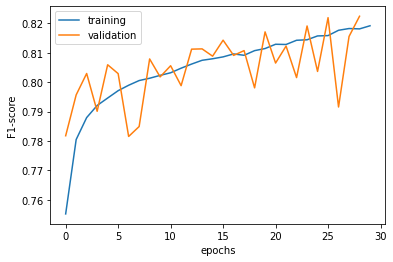

In [26]:
import matplotlib.pyplot as plt

plt.plot(trains)
plt.plot(valids)
plt.legend(['training', 'validation'])
plt.xlabel('epochs')
plt.ylabel('F1-score')

In [ ]:
samp = rand

In [9]:
import random
random.sample(range(0, 1000), 10)

[939, 645, 782, 621, 404, 940, 375, 917, 870, 484]

In [10]:
a = ['sdfd_'+str(i)+'.pkl' for i in range(1000)]

In [11]:
a

['sdfd_0.pkl',
 'sdfd_1.pkl',
 'sdfd_2.pkl',
 'sdfd_3.pkl',
 'sdfd_4.pkl',
 'sdfd_5.pkl',
 'sdfd_6.pkl',
 'sdfd_7.pkl',
 'sdfd_8.pkl',
 'sdfd_9.pkl',
 'sdfd_10.pkl',
 'sdfd_11.pkl',
 'sdfd_12.pkl',
 'sdfd_13.pkl',
 'sdfd_14.pkl',
 'sdfd_15.pkl',
 'sdfd_16.pkl',
 'sdfd_17.pkl',
 'sdfd_18.pkl',
 'sdfd_19.pkl',
 'sdfd_20.pkl',
 'sdfd_21.pkl',
 'sdfd_22.pkl',
 'sdfd_23.pkl',
 'sdfd_24.pkl',
 'sdfd_25.pkl',
 'sdfd_26.pkl',
 'sdfd_27.pkl',
 'sdfd_28.pkl',
 'sdfd_29.pkl',
 'sdfd_30.pkl',
 'sdfd_31.pkl',
 'sdfd_32.pkl',
 'sdfd_33.pkl',
 'sdfd_34.pkl',
 'sdfd_35.pkl',
 'sdfd_36.pkl',
 'sdfd_37.pkl',
 'sdfd_38.pkl',
 'sdfd_39.pkl',
 'sdfd_40.pkl',
 'sdfd_41.pkl',
 'sdfd_42.pkl',
 'sdfd_43.pkl',
 'sdfd_44.pkl',
 'sdfd_45.pkl',
 'sdfd_46.pkl',
 'sdfd_47.pkl',
 'sdfd_48.pkl',
 'sdfd_49.pkl',
 'sdfd_50.pkl',
 'sdfd_51.pkl',
 'sdfd_52.pkl',
 'sdfd_53.pkl',
 'sdfd_54.pkl',
 'sdfd_55.pkl',
 'sdfd_56.pkl',
 'sdfd_57.pkl',
 'sdfd_58.pkl',
 'sdfd_59.pkl',
 'sdfd_60.pkl',
 'sdfd_61.pkl',
 'sdfd_62.pkl',
 '

In [36]:
torch.save(policy.state_dict(), 'trained_params_balanced.pkl')

In [37]:
p = GNNPolicy()

p.load_state_dict(torch.load('trained_params_balanced.pkl'))

# Test the trained policy in the environment

In [5]:
import torch
a = torch.tensor([])
torch.cat((a, torch.tensor([4])))

tensor([4.])

In [17]:
a = torch.cat((a, torch.tensor([4])))
a

tensor([4., 4., 4., 4., 4., 4., 4., 4.])

Text(0, 0.5, 'imitation accuracy')

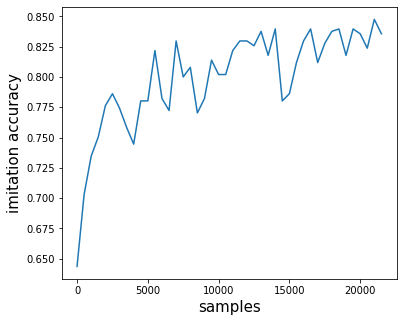

In [16]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(valids))
x = 500*x

fig, axes = plt.subplots(1,1, figsize=(6,5))
plt.plot(x,valids)
plt.xlabel('samples', fontsize=15)
# plt.ylim([0.5,1])

plt.ylabel('imitation accuracy', fontsize=15)

In [17]:
fig.savefig('imitation_acc.pdf')

In [4]:
!pip install matplotlib


     |████████████████████████████████| 11.5 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 23.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 29.5 MB/s eta 0:00:01


In [52]:
torch.save(policy.state_dict(), 'trained_models/trained_params.pkl')

In [59]:
policy_net = policy

In [73]:
import torch.nn as nn
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric
from gnn_dataset import BipartiteNodeData, GraphDataset
from gnn_policy import GNNPolicy, BipartiteGraphConvolution
from tqdm import tqdm
from pathlib import Path

class Episode(object):
    def __init__(self):
        self.reward_history = []
        self.reward_history = []
        self.loss_history = []
        self.gamma = 0.99
        
episode = Episode()


def get_graph_from_obs(sample_observation, sample_action_set):
       
        sample_action_id = sample_action_set[0] # doen't matter won't be used
        # We note on which variables we were allowed to branch, the scores as well as the choice 
        # taken by expert branching (relative to the candidates)
        candidates = torch.LongTensor(np.array(sample_action_set, dtype=np.int32))
        candidate_choice = torch.where(candidates == sample_action_id)[0][0]

        graph = BipartiteNodeData(sample_observation.antenna_features, sample_observation.edge_index, 
                                  sample_observation.edge_features, sample_observation.variable_features,
                                  candidates, candidate_choice)
        
        # We must tell pytorch geometric how many nodes there are, for indexing purposes
        graph.num_nodes = sample_observation.antenna_features.shape[0] + sample_observation.variable_features.shape[0]
        
        return graph

class Policy(nn.Module):
    def __init__(self, init_policy_net, temperature):
        super().__init__()
        self.policy_net = init_policy_net
        self.temperature = temperature
        self.sf = nn.Softmax()
        
        # Episode policy and reward history 
        self.policy_history = torch.Tensor()
        self.reward_episode = []
        
        # Overall reward and loss history
        self.reward_history = []
        self.loss_history = []
        
    def forward(self, state, action_set):
        logits = self.policy_net(state.antenna_features, state.edge_index, state.edge_features, state.variable_features)
        prob = Categorical(self.sf(logits/self.temperature))
        action_id = prob.sample()
        
        # Add log probability of our chosen action to our history    
        if self.policy_history.dim() != 0:
            self.policy_history = torch.cat([self.policy_history, prob.log_prob(action_id)])
        else:
            self.policy_history = (prob.log_prob(action_id))
        return action_id
    

def update_policy():
    R = 0
    rewards = []
    
    # Discount future rewards back to the present using gamma
    for r in policy.reward_episode[::-1]:
        R = r + policy.gamma * R
        rewards.insert(0,R)
        
    # Scale rewards
    rewards = torch.FloatTensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    
    # Calculate loss
    loss = (torch.sum(torch.mul(policy.policy_history, Variable(rewards)).mul(-1), -1))
    
    # Update network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #Save and intialize episode history counters
    policy.loss_history.append(loss.data[0])
    policy.reward_history.append(np.sum(policy.reward_episode))
    policy.policy_history = Variable(torch.Tensor())
    policy.reward_episode= []
    


In [74]:
# add policy network
MAX_ITER = 1000
punishment_for_incomplete_episode = -1000

# load and initialize policy
temperature = 2
policy = Policy(policy_net, temperature)
env = ACRBBenv()

def main(num_episodes):
    running_reward = -1
    avg_length = []
    for i in range(num_episodes):
        instance
        obs, action_set, reward, done, _ = env.reset()
        if done:
            policy.reward_episode.append(reward)
            update_policy()
            continue
        
        for it in range(MAX_ITER):
            state = get_graph_from_obs(obs, action_set)
            action_id = policy(state, state)
            # Step through environment using chosen action
            obs, action_set, reward, done, _ = env.step(action_set[action_id])
            # Save reward
            policy.reward_episode.append(reward)
            if done:
                break
        if not done:
            policy.reward_episode.append(punishment_for_incomplete_episode)
        update_policy()
        avg_length.append(it)
        if episode % 5 == 0:
            print('Episode {}\tAverage length: {:.2f}'.format(episode, np.mean(avg_length)))
            avg_length = []


SyntaxError: invalid syntax (<ipython-input-74-55a82e910406>, line 8)

In [70]:
import numpy as np
np.mean([1,2,3])

2.0

In [72]:
num_episodes = 100
main(num_episodes)

NameError: name 'env' is not defined

In [10]:
import torch.nn as nn
from torch.distributions import Categorical

a = nn.Softmax()
b = a(torch.rand(5))
m = Categorical(b)
action = m.sample()

/scratch/sagar/Projects/combopt/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


In [2]:
import torch_geometric

In [12]:
m.log_prob(action)

tensor(-1.6983)